In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


Results for Train/Test Split 80/19:
SVM Accuracy: 0.88
              precision    recall  f1-score   support

           0       0.87      0.94      0.90        35
           1       0.91      0.80      0.85        25

    accuracy                           0.88        60
   macro avg       0.89      0.87      0.88        60
weighted avg       0.89      0.88      0.88        60



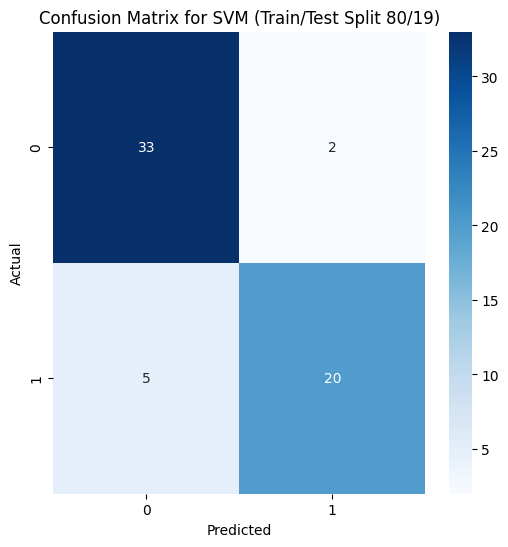

Decision Tree Accuracy: 0.80
              precision    recall  f1-score   support

           0       0.85      0.80      0.82        35
           1       0.74      0.80      0.77        25

    accuracy                           0.80        60
   macro avg       0.79      0.80      0.80        60
weighted avg       0.80      0.80      0.80        60



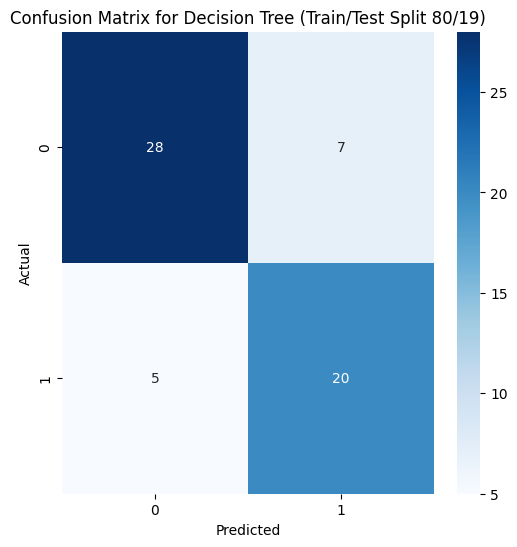

Random Forest Accuracy: 0.87
              precision    recall  f1-score   support

           0       0.86      0.91      0.89        35
           1       0.87      0.80      0.83        25

    accuracy                           0.87        60
   macro avg       0.87      0.86      0.86        60
weighted avg       0.87      0.87      0.87        60



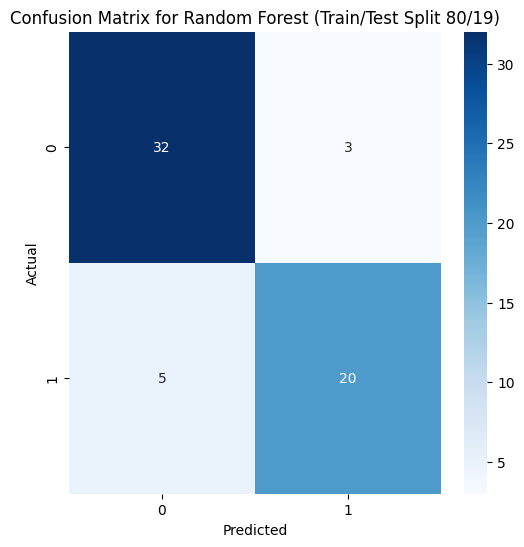


Results for Train/Test Split 50/50:
SVM Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.77      0.87      0.82        75
           1       0.85      0.75      0.79        75

    accuracy                           0.81       150
   macro avg       0.81      0.81      0.81       150
weighted avg       0.81      0.81      0.81       150



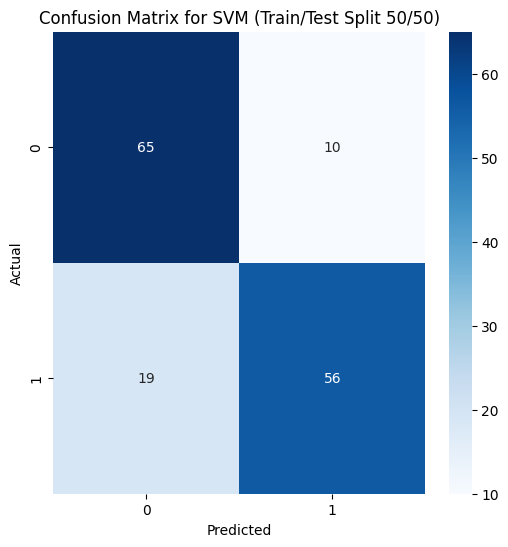

Decision Tree Accuracy: 0.71
              precision    recall  f1-score   support

           0       0.69      0.77      0.73        75
           1       0.74      0.65      0.70        75

    accuracy                           0.71       150
   macro avg       0.72      0.71      0.71       150
weighted avg       0.72      0.71      0.71       150



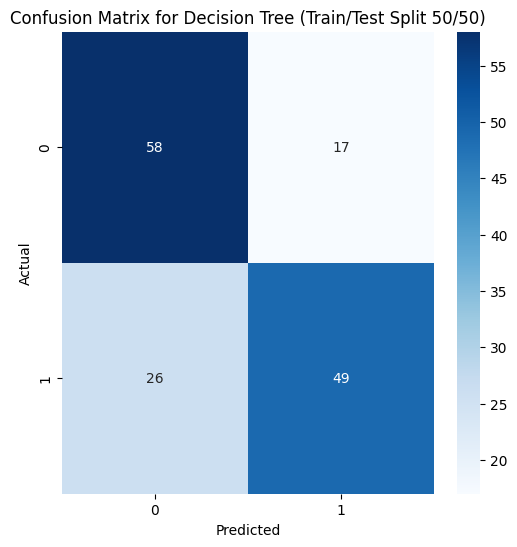

Random Forest Accuracy: 0.83
              precision    recall  f1-score   support

           0       0.79      0.91      0.84        75
           1       0.89      0.76      0.82        75

    accuracy                           0.83       150
   macro avg       0.84      0.83      0.83       150
weighted avg       0.84      0.83      0.83       150



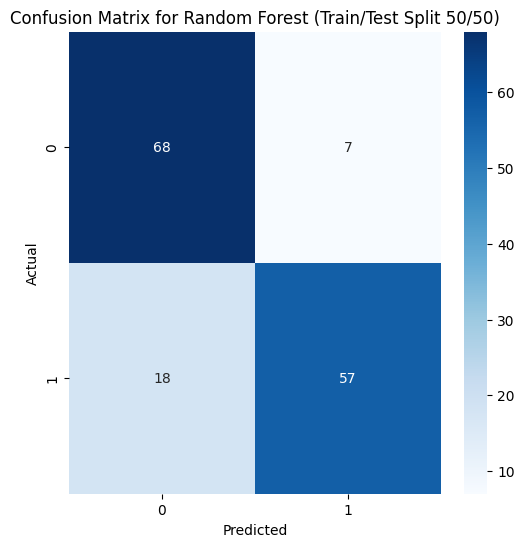


Results for Train/Test Split 20/80:
SVM Accuracy: 0.80
              precision    recall  f1-score   support

           0       0.76      0.89      0.82       121
           1       0.87      0.71      0.78       119

    accuracy                           0.80       240
   macro avg       0.81      0.80      0.80       240
weighted avg       0.81      0.80      0.80       240



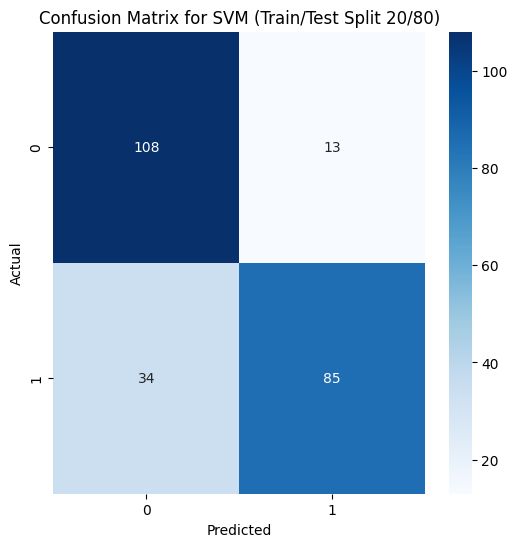

Decision Tree Accuracy: 0.64
              precision    recall  f1-score   support

           0       0.62      0.74      0.67       121
           1       0.67      0.54      0.60       119

    accuracy                           0.64       240
   macro avg       0.64      0.64      0.63       240
weighted avg       0.64      0.64      0.63       240



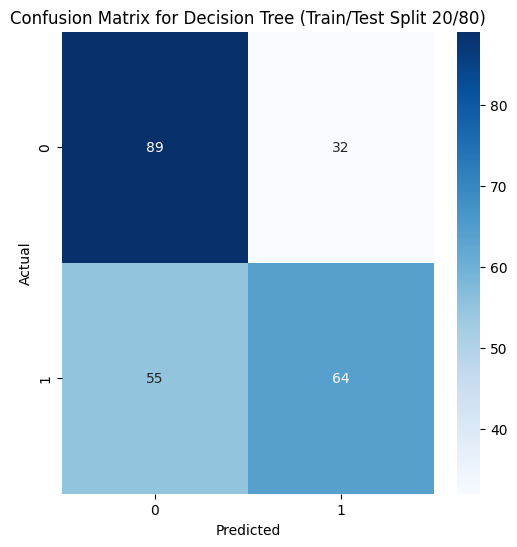

Random Forest Accuracy: 0.80
              precision    recall  f1-score   support

           0       0.74      0.94      0.83       121
           1       0.92      0.66      0.77       119

    accuracy                           0.80       240
   macro avg       0.83      0.80      0.80       240
weighted avg       0.83      0.80      0.80       240



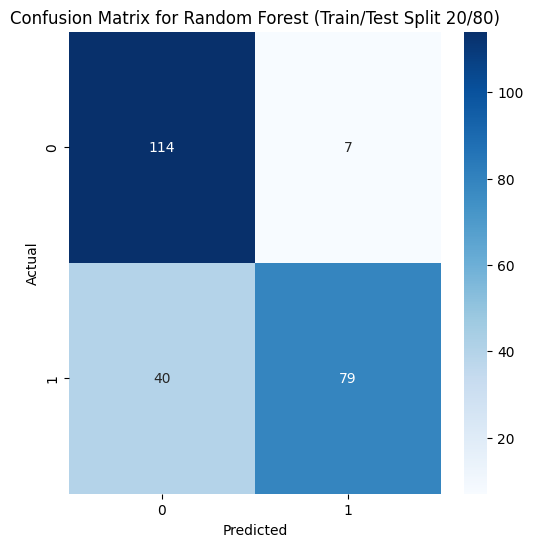


Average Accuracies for Each Partition:

Train/Test Split 80/19:
SVM: 0.88
Decision Tree: 0.80
Random Forest: 0.87

Train/Test Split 50/50:
SVM: 0.81
Decision Tree: 0.71
Random Forest: 0.83

Train/Test Split 20/80:
SVM: 0.80
Decision Tree: 0.64
Random Forest: 0.80


In [9]:
# File paths for processed datasets
cleveland_path = "processed.cleveland.data"
hungarian_path = "processed.hungarian.data"
switzerland_path = "processed.switzerland.data"
va_path = "processed.va.data"

# Load and concatenate datasets
def load_and_clean_data(paths):
    datasets = []
    for path in paths:
        # Load data
        raw_data = pd.read_csv(path, header=None)
        # Replace missing values with NaN
        raw_data.replace({'?': np.nan, '.': np.nan}, inplace=True)
        # Convert all data to numeric
        cleaned_data = raw_data.apply(pd.to_numeric, errors='coerce')
        # Append to list
        datasets.append(cleaned_data)
    # Concatenate all datasets
    combined_data = pd.concat(datasets, ignore_index=True)
    # Drop rows with missing values
    combined_data.dropna(inplace=True)
    return combined_data

# Load and clean the data
paths = [cleveland_path, hungarian_path, switzerland_path, va_path]
data = load_and_clean_data(paths)

# Split features and target
X = data.iloc[:, :-1]  # All columns except the last one
y = data.iloc[:, -1]  # Last column as target

# Convert target to binary classification (0: negative, 1: positive)
y = (y > 0).astype(int)

# Initialize classifiers
svm = SVC(random_state=42)
decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)

# Hyperparameter grids
param_grids = {
    "SVM": {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]},
    "Decision Tree": {"max_depth": [None, 10, 20, 30], "min_samples_split": [2, 5, 10]},
    "Random Forest": {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20]}
}

# Function to evaluate classifiers with different partitions
def evaluate_with_partitions(X, y, partitions):
    results = {}
    average_accuracies_by_partition = {}

    for partition in partitions:
        test_size = 1 - partition
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

        partition_results = {}
        partition_accuracies = {"SVM": [], "Decision Tree": [], "Random Forest": []}

        for name, model, param_grid in zip(
            ["SVM", "Decision Tree", "Random Forest"],
            [svm, decision_tree, random_forest],
            [param_grids["SVM"], param_grids["Decision Tree"], param_grids["Random Forest"]]
        ):
            grid_search = GridSearchCV(model, param_grid, cv=3, scoring="accuracy")
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_

            # Predictions and evaluation
            y_pred = best_model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            partition_accuracies[name].append(accuracy)

            partition_results[name] = {
                "accuracy": accuracy,
                "classification_report": classification_report(y_test, y_pred, output_dict=False),
                "confusion_matrix": confusion_matrix(y_test, y_pred)
            }

        # Calculate and store average accuracies for this partition
        average_accuracies_by_partition[f"Train/Test Split {int(partition * 100)}/{int((1 - partition) * 100)}"] = {
            classifier: np.mean(acc) for classifier, acc in partition_accuracies.items()
        }

        results[f"Train/Test Split {int(partition * 100)}/{int((1 - partition) * 100)}"] = partition_results

    return results, average_accuracies_by_partition

# Evaluate models on 80/20, 50/50, and 20/80 splits
partitions = [0.8, 0.5, 0.2]
results, average_accuracies_by_partition = evaluate_with_partitions(X, y, partitions)

# Display results
for split, split_results in results.items():
    print(f"\nResults for {split}:")
    for name, metrics in split_results.items():
        print(f"{name} Accuracy: {metrics['accuracy']:.2f}")
        print(metrics['classification_report'])

        # Plot confusion matrix
        plt.figure(figsize=(6, 6))
        sns.heatmap(metrics["confusion_matrix"], annot=True, fmt="d", cmap="Blues")
        plt.title(f"Confusion Matrix for {name} ({split})")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

# Display average accuracies for each partition
print("\nAverage Accuracies for Each Partition:")
for split, avg_accuracies in average_accuracies_by_partition.items():
    print(f"\n{split}:")
    for classifier, avg_accuracy in avg_accuracies.items():
        print(f"{classifier}: {avg_accuracy:.2f}")